In [ ]:
!wget ''
!unzip 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd


In [2]:
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img


In [3]:
df = pd.read_csv('data/train_masks.csv')
df.shape

(5088, 2)

In [5]:
train_df = df[:4000]
val_df = df[4000:]

In [5]:
df[:5]

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [6]:
img_name, mask_rle = train_df.iloc[4]

img = cv2.imread('data/train/{}'.format(img_name))
mask = rle_decode(mask_rle)

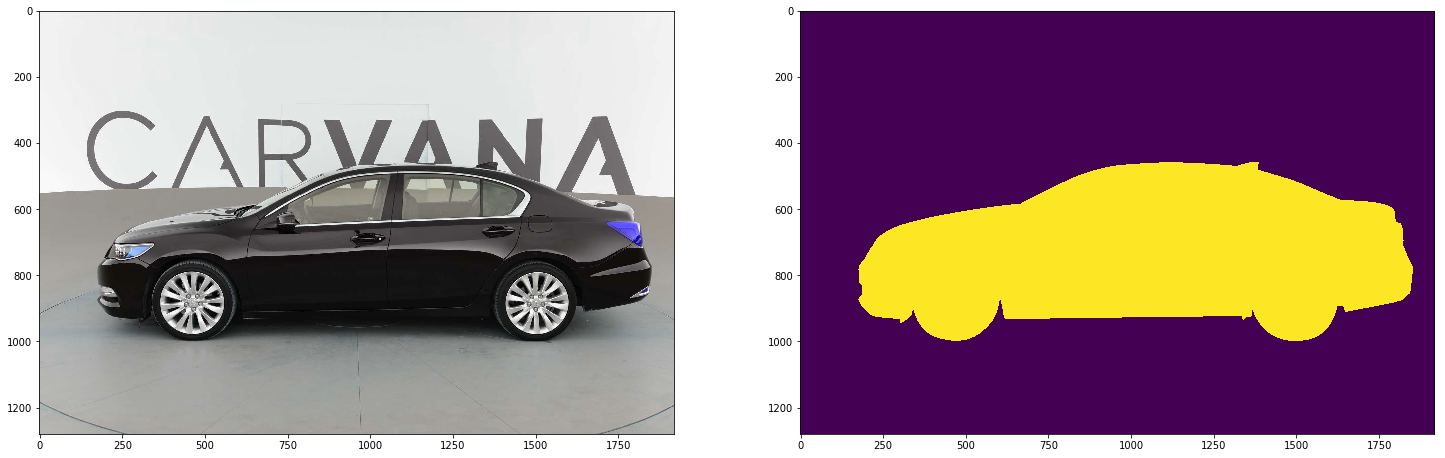

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(img)
axes[1].imshow(mask[..., 0])

plt.show()

In [8]:
def keras_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread('data/train/{}'.format(img_name))
            mask = rle_decode(mask_rle)
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [9]:
for x, y in keras_generator(train_df, 16):
    break

In [10]:
x.shape

(16, 256, 256, 3)

In [11]:
y.shape


(16, 256, 256, 1)

## Layer examples

In [ ]:
UpSampling2D(size=(32, 32), interpolation='bilinear')(layer)
Conv2D(1, (1,1), strides=(1, 1))(layer)
Conv2D(256, (3,3), padding='same')(layer)
Activation('relu')(layer)
Concatenate(axis=-1)([layer_1, layer_2])


# FCN

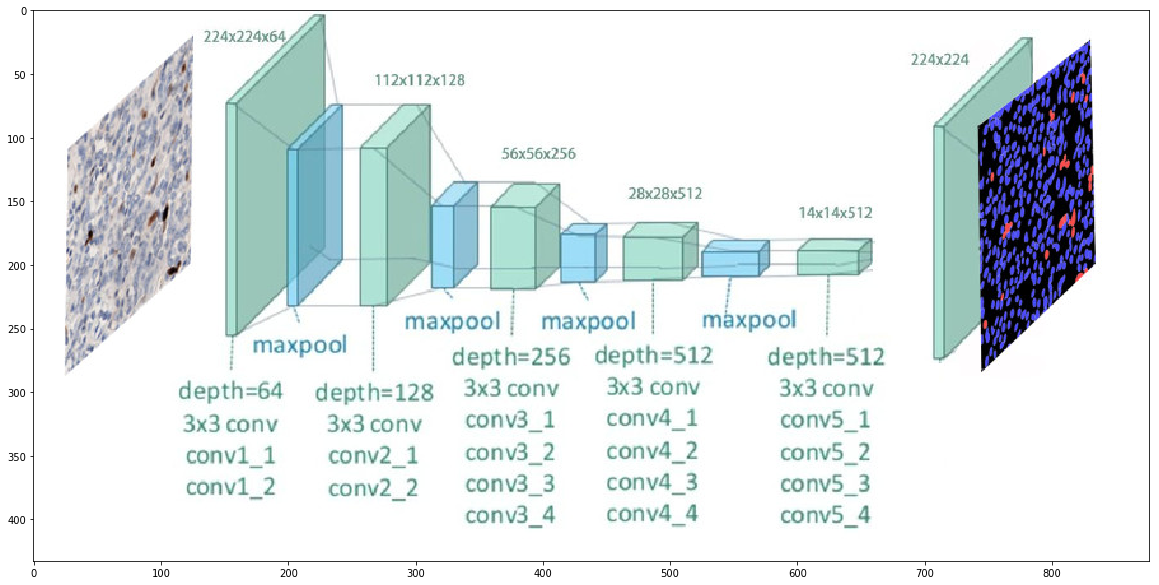

In [11]:
fcn_png = cv2.imread('fcn.jpg')
plt.figure(figsize=(20,20))
plt.imshow(fcn_png[..., [2,1,0]])
plt.show()

In [32]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation


base_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)


base_out = base_model.output


up = UpSampling2D(32, interpolation='bilinear')(base_out)
conv = Conv2D(1, (1, 1))(up)
conv = Activation('sigmoid')(conv)

model = Model(input=base_model.input, output=conv)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in...)`


In [16]:
up

<tf.Tensor 'up_sampling2d_1/ResizeNearestNeighbor:0' shape=(?, 256, 256, 512) dtype=float32>

In [13]:
base_out

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 8, 8, 512) dtype=float32>

In [14]:
256/8

32.0

In [27]:
pred = model.predict(x)

In [28]:
pred.shape

(16, 256, 256, 1)

In [22]:
cv2.resize(pred[0, :, :, 2], (256, 256)).shape

(256, 256)

In [33]:
best_w = keras.callbacks.ModelCheckpoint('fcn_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('fcn_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [34]:
batch_size = 16
model.fit_generator(keras_generator(train_df, batch_size),
              steps_per_epoch=100,
              epochs=3,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/3
100/100 [==============================] - 54s 543ms/step - loss: 0.0893 - val_loss: 0.0418
Epoch 2/3
100/100 [==============================] - 53s 526ms/step - loss: 0.0370 - val_loss: 0.0346
Epoch 3/3
 10/100 [==>...........................] - ETA: 40s - loss: 0.0333

KeyboardInterrupt: 

In [ ]:
pred = model.predict(x)#.shape


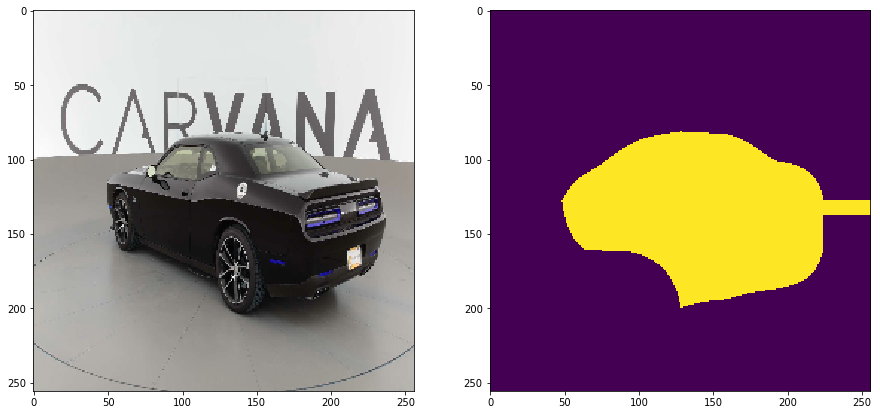

In [43]:

im_id = 13
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

# SegNet

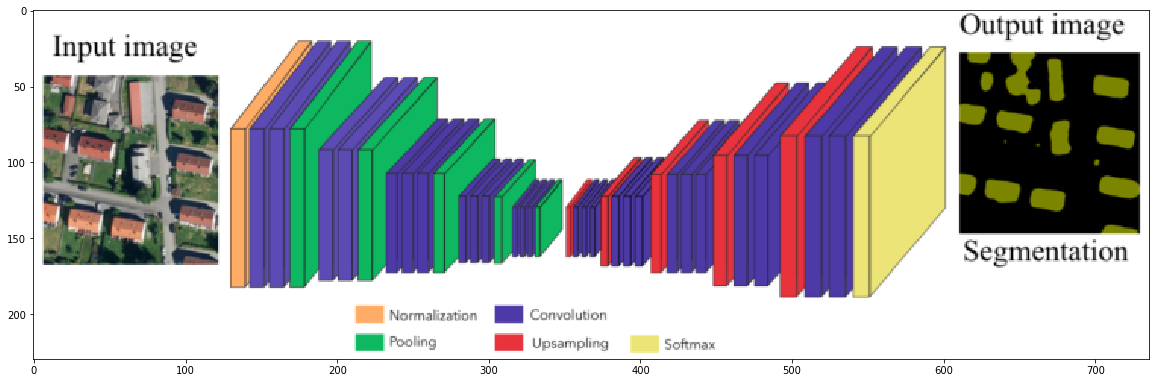

In [174]:
seg_png = cv2.imread('segnet.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

In [75]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D

inp = Input(shape=(256, 256, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)


conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)


conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)


conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)

up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(up_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)


up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(up_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)


up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(up_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)



up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(up_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)
result = Activation('sigmoid')(conv_up_4_2)


model = Model(inputs=inp, outputs=result)

In [84]:
conv_up_4_1

<tf.Tensor 'activation_108/Relu:0' shape=(?, 256, 256, 32) dtype=float32>

In [85]:
conv_1_1

<tf.Tensor 'activation_94/Relu:0' shape=(?, 256, 256, 32) dtype=float32>

In [78]:
best_w = keras.callbacks.ModelCheckpoint('segnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('segnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [79]:
batch_size = 16
model.fit_generator(keras_generator(train_df, batch_size),
              steps_per_epoch=100,
              epochs=15,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/15
100/100 [==============================] - 30s 297ms/step - loss: 0.2708 - val_loss: 0.1383
Epoch 2/15
100/100 [==============================] - 28s 277ms/step - loss: 0.0972 - val_loss: 0.0707
Epoch 3/15
100/100 [==============================] - 28s 277ms/step - loss: 0.0604 - val_loss: 0.0478
Epoch 4/15
100/100 [==============================] - 28s 278ms/step - loss: 0.0424 - val_loss: 0.0365
Epoch 5/15
100/100 [==============================] - 28s 280ms/step - loss: 0.0342 - val_loss: 0.0309
Epoch 6/15
100/100 [==============================] - 28s 279ms/step - loss: 0.0306 - val_loss: 0.0311
Epoch 7/15
100/100 [==============================] - 28s 280ms/step - loss: 0.0264 - val_loss: 0.0267
Epoch 8/15
100/100 [==============================] - 28s 282ms/step - loss: 0.0248 - val_loss: 0.0247
Epoch 9/15
100/100 [==============================] - 28s 282ms/step - loss: 0.0227 - val_loss: 0.0227
Epoch 10/15
100/100 [==============================] - 28s 283ms/step - l

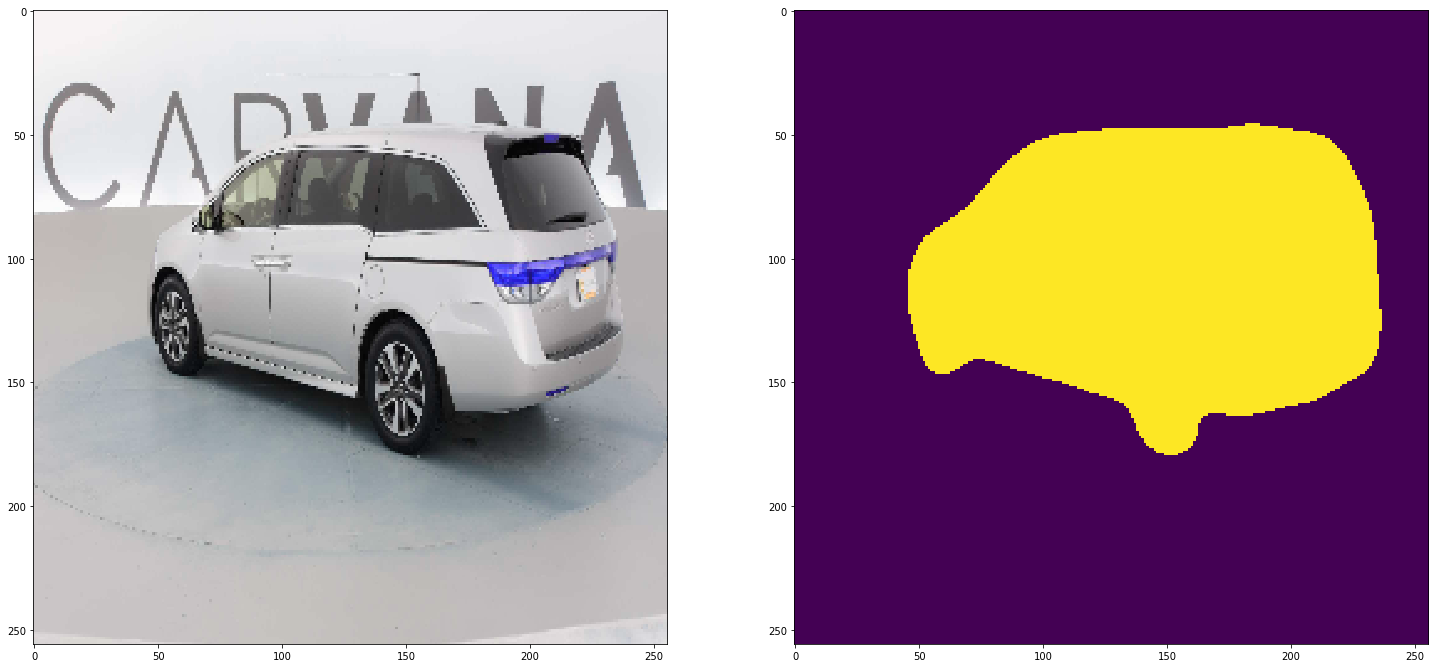

In [83]:
pred = model.predict(x)#.shape

im_id = 14
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

# Vanilla Unet

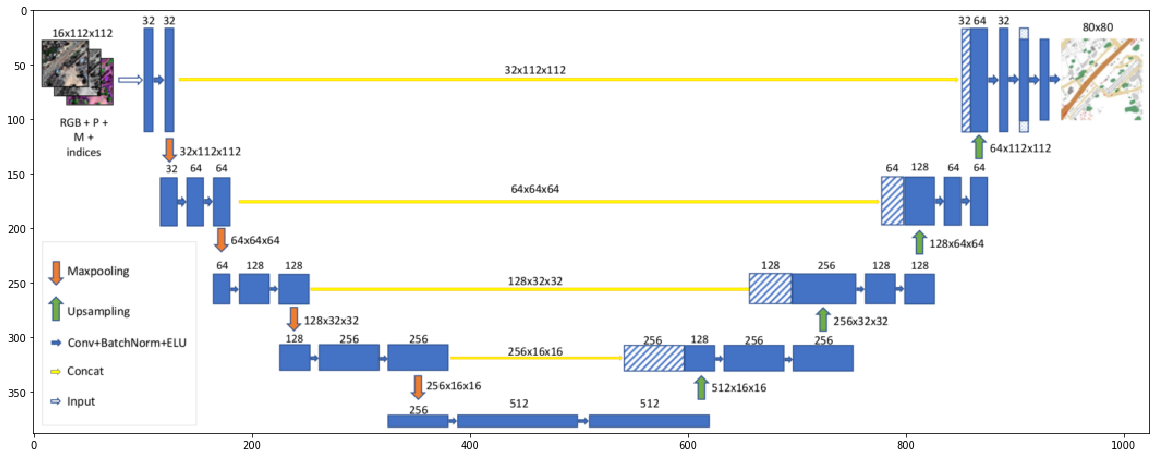

In [124]:
seg_png = cv2.imread('unet.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

In [93]:
pool_4, up_1

(<tf.Tensor 'max_pooling2d_39/MaxPool:0' shape=(?, 16, 16, 256) dtype=float32>,
 <tf.Tensor 'up_sampling2d_24/ResizeBilinear:0' shape=(?, 32, 32, 256) dtype=float32>)

In [94]:
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D

inp = Input(shape=(256, 256, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)


conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)


conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)


conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)

up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conc_1 = Concatenate()([conv_4_2, up_1])

conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)


up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_3_2, up_2])

conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)


up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_2_2, up_3])

conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)



up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([conv_1_2, up_4])
conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)
result = Activation('sigmoid')(conv_up_4_2)


model = Model(inputs=inp, outputs=result)

In [97]:
best_w = keras.callbacks.ModelCheckpoint('unet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('unet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [98]:
batch_size = 16
model.fit_generator(keras_generator(train_df, batch_size),
              steps_per_epoch=100,
              epochs=100,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/100
100/100 [==============================] - 34s 339ms/step - loss: 0.3675 - val_loss: 0.1368
Epoch 2/100
100/100 [==============================] - 32s 320ms/step - loss: 0.0909 - val_loss: 0.0704
Epoch 3/100
100/100 [==============================] - 32s 322ms/step - loss: 0.0485 - val_loss: 0.0428
Epoch 4/100
100/100 [==============================] - 32s 322ms/step - loss: 0.0319 - val_loss: 0.0297
Epoch 5/100
100/100 [==============================] - 32s 323ms/step - loss: 0.0283 - val_loss: 0.0281
Epoch 6/100
100/100 [==============================] - 33s 326ms/step - loss: 0.0244 - val_loss: 0.0256
Epoch 7/100
  9/100 [=>............................] - ETA: 22s - loss: 0.0241

KeyboardInterrupt: 

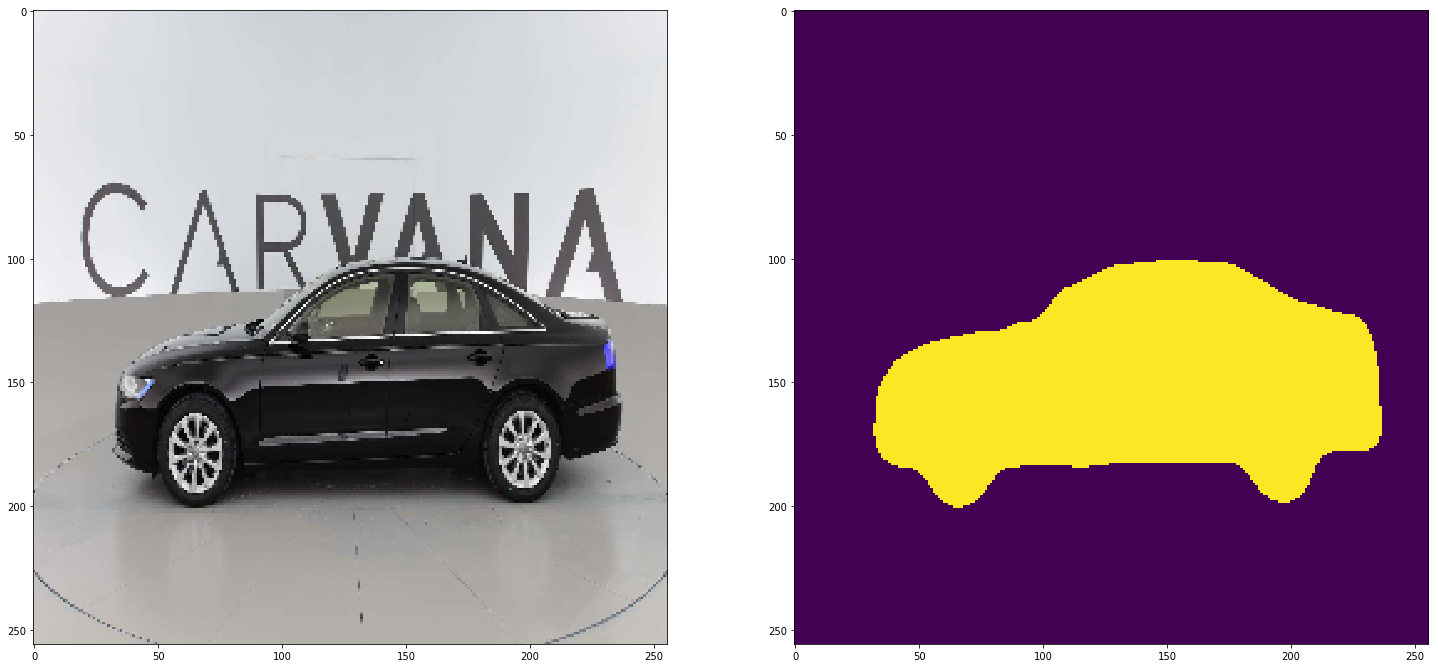

In [103]:
pred = model.predict(x)#.shape

im_id = 5
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

# Unet with ResNet34 encoder

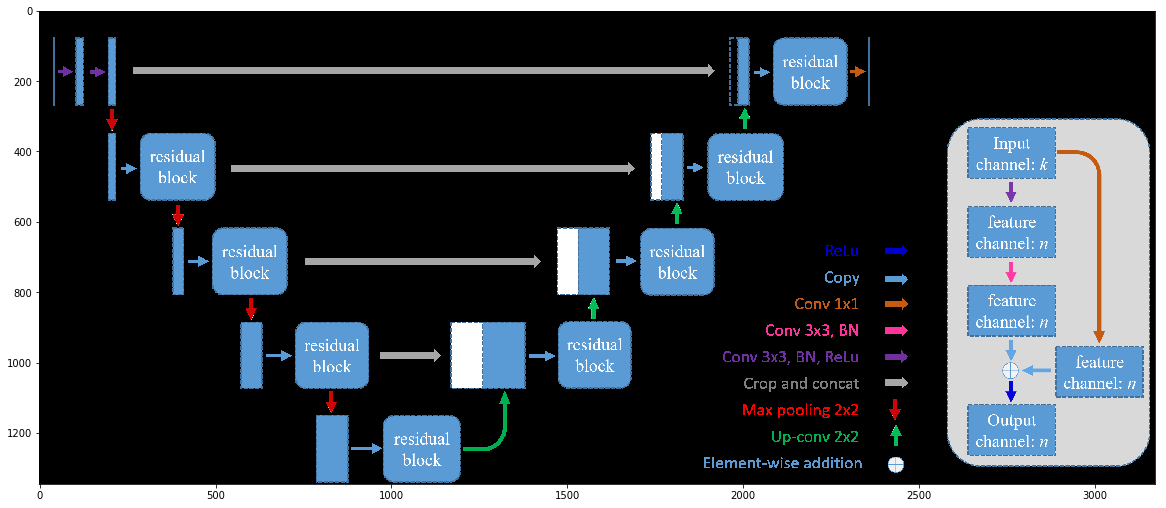

In [35]:
seg_png = cv2.imread('unet_resnet_strucutre_new.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

In [104]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Concatenate, Activation
from keras import backend as K

# create the base pre-trained model
base_model = ResNet50(weights='imagenet', input_shape=(256,256,3), include_top=False)
 
base_out = base_model.output

# up = UpSampling2D(size=(32, 32), data_format=None, interpolation='bilinear')(base_out)
# up = Conv2D(1, (1,1), strides=(1, 1))(up)


# model = Model(input=base_model.input, output=up)

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [106]:
base_out

<tf.Tensor 'activation_182/Relu:0' shape=(?, 8, 8, 2048) dtype=float32>

In [107]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_27[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [115]:
conv1 = base_model.get_layer('activation_134').output
conv2 = base_model.get_layer('activation_137').output
conv3 = base_model.get_layer('activation_147').output
conv4 = base_model.get_layer('activation_160').output
conv5 = base_model.get_layer('activation_175').output


## CODE

inp = base_model.get_layer('input_27').output

In [116]:
conv1

<tf.Tensor 'activation_134/Relu:0' shape=(?, 128, 128, 64) dtype=float32>

In [117]:
conv2

<tf.Tensor 'activation_137/Relu:0' shape=(?, 64, 64, 256) dtype=float32>

In [118]:
conv3

<tf.Tensor 'activation_147/Relu:0' shape=(?, 32, 32, 128) dtype=float32>

In [119]:
conv4

<tf.Tensor 'activation_160/Relu:0' shape=(?, 16, 16, 256) dtype=float32>

In [120]:
conv5

<tf.Tensor 'activation_175/Relu:0' shape=(?, 8, 8, 512) dtype=float32>

In [140]:
up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
conc_1 = Concatenate()([up1, conv4])
conv_conc_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_conc_1 = Activation('relu')(conv_conc_1)

up2 = UpSampling2D(2, interpolation='bilinear')(conv_conc_1)
conc_2 = Concatenate()([up2, conv3])
conv_conc_2 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_conc_2 = Activation('relu')(conv_conc_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_conc_2)
conc_3 = Concatenate()([up3, conv2])
conv_conc_3 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_conc_3 = Activation('relu')(conv_conc_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv1])
conv_conc_4 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_conc_4 = Activation('relu')(conv_conc_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conv_conc_5 = Conv2D(3, (3, 3), padding='same')(up5)
conv_conc_5 = Activation('softmax')(conv_conc_5)


In [141]:
conv_conc_5

<tf.Tensor 'activation_190/Sigmoid:0' shape=(?, 256, 256, 1) dtype=float32>

In [144]:
model = Model(input=base_model.input, output=conv_conc_5)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [145]:
best_w = keras.callbacks.ModelCheckpoint('resnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('resnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [146]:
batch_size = 16
model.fit_generator(keras_generator(train_df, batch_size),
              steps_per_epoch=100,
              epochs=100,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/100
100/100 [==============================] - 44s 436ms/step - loss: 0.0582 - val_loss: 0.0241
Epoch 2/100
100/100 [==============================] - 34s 337ms/step - loss: 0.0182 - val_loss: 0.0163
Epoch 3/100
100/100 [==============================] - 34s 337ms/step - loss: 0.0148 - val_loss: 0.0151
Epoch 4/100
100/100 [==============================] - 33s 334ms/step - loss: 0.0126 - val_loss: 0.0143
Epoch 5/100
100/100 [==============================] - 33s 333ms/step - loss: 0.0117 - val_loss: 0.0125
Epoch 6/100
100/100 [==============================] - 34s 335ms/step - loss: 0.0112 - val_loss: 0.0123
Epoch 7/100
100/100 [==============================] - 34s 343ms/step - loss: 0.0106 - val_loss: 0.0119
Epoch 8/100
100/100 [==============================] - 34s 343ms/step - loss: 0.0098 - val_loss: 0.0115
Epoch 9/100
100/100 [==============================] - 34s 338ms/step - loss: 0.0093 - val_loss: 0.0111
Epoch 10/100
  3/100 [..............................] - ETA: 24s

KeyboardInterrupt: 

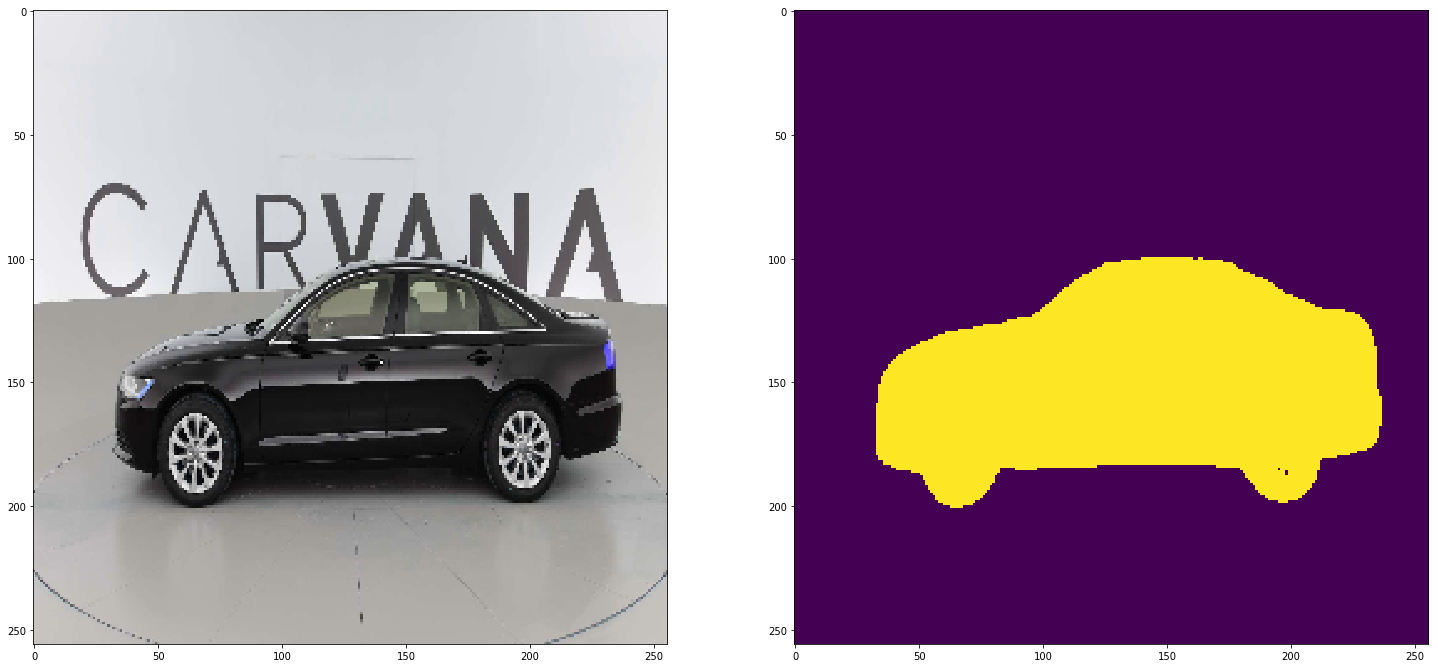

In [151]:
pred = model.predict(x)#.shape

im_id = 5
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] >0.5)

plt.show()

In [ ]:
https://github.com/qubvel/segmentation_models

# Аугментации

In [172]:
from albumentations import (
    CLAHE, RandomRotate90, Transpose, RandomCrop, Resize, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, HorizontalFlip, OneOf, Compose, PadIfNeeded, LongestMaxSize, PadIfNeeded, ElasticTransform,Cutout
)




def strong_aug(p=1.0):
    return Compose([
        ShiftScaleRotate(shift_limit=0.125, scale_limit=0.2, rotate_limit=10, p=0.7, border_mode=cv2.BORDER_CONSTANT),
        RandomCrop(256, 256),
        #PadIfNeeded(min_height=224, min_width=224, border_mode=cv2.BORDER_CONSTANT, p=1.0),
        #Resize(64, 64),
        #RandomRotate90(),
        ElasticTransform(1.), 
        #HorizontalFlip(),
        #Cutout(p=1.),
        #Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.3),
        OneOf([
            MotionBlur(p=.4),
            MedianBlur(blur_limit=3, p=0.3),
            Blur(blur_limit=3, p=0.3),
        ], p=0.5),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.5),
        OneOf([
            CLAHE(clip_limit=3),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.4),
        HueSaturationValue(p=0.7),
         
        
        
    ],
        p=p)

In [160]:
img = cv2.imread('prepod.jpg')
mask = cv2.imread('prepod_mak.jpg')

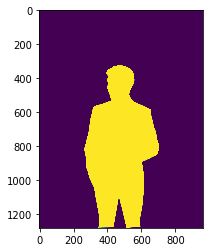

In [157]:
plt.imshow(mask[..., 0])

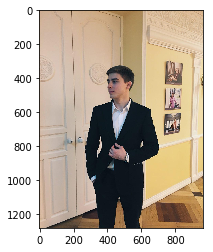

In [153]:
plt.imshow(img[..., [2,1,0]])

In [157]:
img.shape

(500, 500, 3)

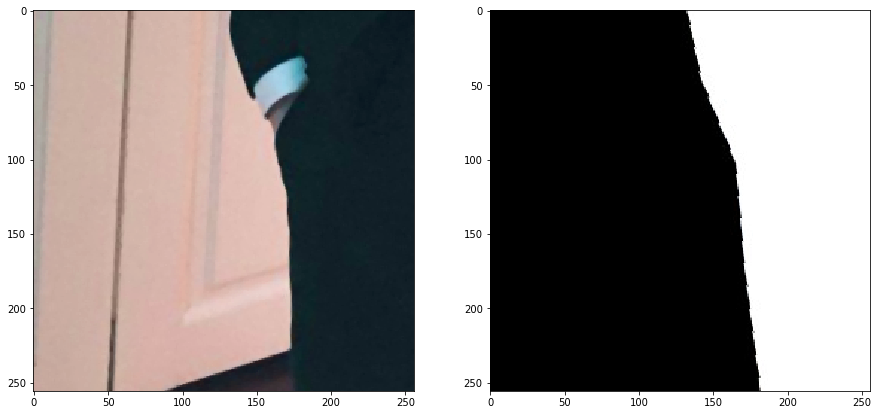

In [194]:
augmentation = strong_aug(p=1.0)


data = {'image': img.astype('uint8'), 'mask': mask}
augmented = augmentation(**data)
crop_img, crop_mask = augmented["image"], augmented["mask"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(crop_img[..., [2,1,0]])
axes[1].imshow(crop_mask)

plt.show()